In [1]:
import numpy as np
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from cebefo_style import Set_2D_colz_graphics

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Preliminary"

donotdelete = []

Welcome to JupyROOT 6.10/08


In [2]:
# %jsroot on

In [3]:
from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel

In [4]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

# Data loading

In [5]:
tMC = ur.open('../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0/B02DstMu_candidates.root')['outA']['Tevts']
print tMC.keys(), '\n\n'
branches = tMC.keys()
for b in np.sort(branches):
    print b

['LumiBlock', 'MC_B_P', 'MC_B_eta', 'MC_B_phi', 'MC_B_pt', 'MC_D0_P', 'MC_D0_eta', 'MC_D0_phi', 'MC_D0_pt', 'MC_Dst_P', 'MC_Dst_eta', 'MC_Dst_phi', 'MC_Dst_pt', 'MC_Est_mu', 'MC_M2_miss', 'MC_mu_P', 'MC_mu_eta', 'MC_mu_phi', 'MC_mu_pt', 'MC_pis_P', 'MC_pis_eta', 'MC_pis_phi', 'MC_pis_pt', 'MC_q2', 'Run', 'eventNumber', 'n_B', 'n_D0', 'n_Dst', 'n_K', 'n_pi', 'n_pis', 'trgMu_charge', 'trgMu_eta', 'trgMu_phi', 'trgMu_pt', 'B_E', 'B_P', 'B_eta', 'B_phi', 'B_pt', 'B_pz', 'D0_E', 'D0_P', 'D0_eta', 'D0_phi', 'D0_pt', 'D0_pz', 'Dst_E', 'Dst_P', 'Dst_eta', 'Dst_phi', 'Dst_pt', 'Dst_pz', 'Est_mu', 'K_E', 'K_P', 'K_eta', 'K_phi', 'K_pt', 'K_pz', 'M2_miss', 'chi2_D0pis', 'chi2_MuDst', 'chi2_kpi', 'cos_D0pis_vtxMu', 'cos_MuDst_vtxBest', 'cos_kpi_vtxMu', 'd_vtxD0pis_vtxMu', 'd_vtxkpi_vtxMu', 'dca_D0pis_vtxMu', 'dca_kpi_vtxMu', 'mass_D0pis', 'mass_MuDst', 'mass_kpi', 'mu_E', 'mu_P', 'mu_eta', 'mu_phi', 'mu_pt', 'mu_pz', 'pi_E', 'pi_P', 'pi_eta', 'pi_phi', 'pi_pt', 'pi_pz', 'pis_E', 'pis_P', 'pis_eta'

In [6]:
file_loc = {}
file_loc['data'] = '../data/cmsRD/Run2018D/B02DstMu_190517_BPH*.root'
file_loc['mu'] = '../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0/B02DstMu_candidates/out*.root'
file_loc['tau'] = '../data/cmsMC_private/BPH_Tag-B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0/B02DstMu_candidates/out*.root'

In [7]:
dSet = {}
for k, fn in file_loc.iteritems():
    dSet[k] = extarct_multiple(fn, branches=branches, flag=k)
    print k, ':', dSet[k]['Est_mu'].shape[0], 'candidates'

mu : 15963 candidates
tau : 7222 candidates
data : 323091 candidates


# Analysis parameters

Selection declaration

In [80]:
analysis_selection = {}
analysis_selection['mass_MuDst'] = ['<', 5.280]
analysis_selection['cos_MuDst_vtxBest'] = ['>', 0.98]
analysis_selection['q2'] = ['>', -2]
# analysis_selection['M2_miss'] = ['>', -2]

Binning declaration

In [81]:
binning = {}
binning['q2'] = [4, -2, 10.7]
binning['M2_miss'] = [40/2, -5, 8]
binning['Est_mu'] = [30/2, 0.10, 2.500]

# Create histograms

In [82]:
histo= {}
for k in file_loc.keys():
    histo[k] = rt.TH3F('h_'+k, k, 
                     binning['q2'][0], binning['q2'][1], binning['q2'][2],
                     binning['M2_miss'][0], binning['M2_miss'][1], binning['M2_miss'][2],      
                     binning['Est_mu'][0], binning['Est_mu'][1], binning['Est_mu'][2]
                    )

    d = dSet[k]
    sel = createSel(d, analysis_selection)
    
    aux = {}
    for kk in binning.keys():
        aux[kk] = np.copy(d[kk][sel])
        
        low_v = binning[kk][1] + 0.5*float(binning[kk][2] - binning[kk][1])/binning[kk][0]
        aux[kk][aux[kk] < binning[kk][1]] = low_v
        
        high_v = binning[kk][2] - 0.5*float(binning[kk][2] - binning[kk][1])/binning[kk][0]
        aux[kk][aux[kk] > binning[kk][2]] = high_v
    
    rtnp.fill_hist(histo[k], np.column_stack((aux['q2'], aux['M2_miss'], aux['Est_mu'])))

In [83]:
for k,h in histo.iteritems():
    print k, ':', h.Integral()

mu : 15696.0
tau : 7128.0
data : 316427.0


In [84]:
if False:
    tf = rt.TFile('../data/_root/histos_3D.root', 'recreate')
    for k,v in histo.iteritems():
        v.Write()
    tf.Close()

# Fit just $q^2$

In [85]:
h_q2 = {}
bin_q2_only = [50, -5, 12]
leg = rt.TLegend(0.5,0.6,0.9,0.9)
for k in file_loc.keys():
    d = dSet[k]
    sel = createSel(d, analysis_selection)
    
    aux = np.copy(d['q2'][sel])
        
    low_v = bin_q2_only[1] + 0.5*float(bin_q2_only[2] - bin_q2_only[1])/bin_q2_only[0]
    aux[aux < bin_q2_only[1]] = low_v

    high_v = bin_q2_only[2] - 0.5*float(bin_q2_only[2] - bin_q2_only[1])/bin_q2_only[0]
    aux[aux > bin_q2_only[2]] = high_v
    
    h_q2[k] = create_TH1D(aux, name='h_q2_'+k, binning=bin_q2_only)
    h_q2[k].Sumw2()

In [86]:
# if True:
#     tf = rt.TFile('../data/_root/histos_1Dq2.root', 'recreate')
#     for k,v in h_q2.iteritems():
#         if k == 'mu':
#             v.Scale(h_q2['data'].GetEntries()*0.99/v.GetEntries())
#         if k == 'tau':
#             v.Scale(h_q2['data'].GetEntries()*0.01/v.GetEntries())
#         v.Write()
#     tf.Close()

In [87]:
N_data = h_q2['data'].Integral()
test_raw_yeld = 0.1

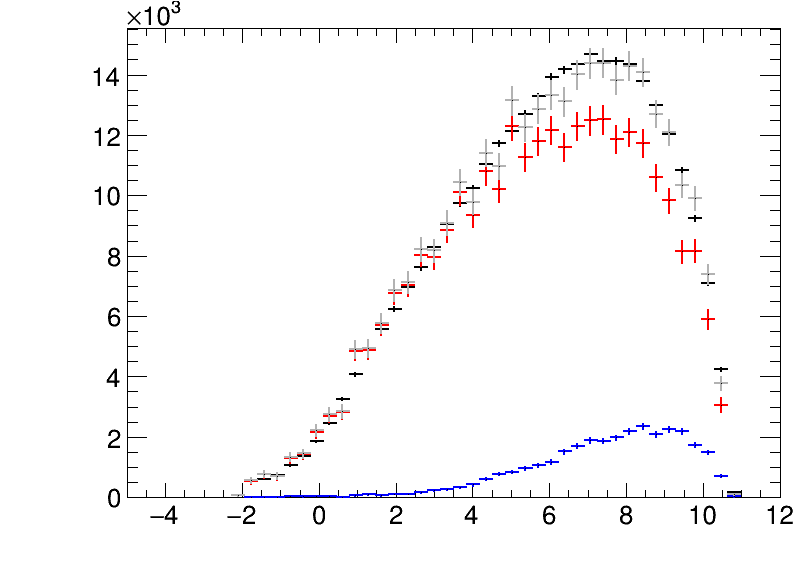

In [88]:
c =  rt.TCanvas('c', 'c', 800,600)
h_q2['data'].Draw()
h_q2['mu'].Scale(N_data*(1-test_raw_yeld)/h_q2['mu'].Integral())
h_q2['mu'].SetLineColor(2)
# h_q2['mu'].Sumw2(0)
h_q2['mu'].Draw('SAME')

h_q2['tau'].Scale(N_data*test_raw_yeld/h_q2['tau'].Integral())
h_q2['tau'].SetLineColor(4)
# h_q2['tau'].Sumw2(0)
h_q2['tau'].Draw('SAME')

h_sum = h_q2['mu'].Clone('h_sum')
h_sum.Add(h_q2['mu'], h_q2['tau'])
h_sum.SetLineColor(16)
h_sum.Draw('SAME')

c.Draw()

In [113]:
q2 = rt.RooRealVar('q2', 'q^{2}', bin_q2_only[1], bin_q2_only[2], 'GeV^{2}')

data = rt.RooDataHist('Data', 'Data', rt.RooArgList(q2), h_q2['data'])

dh_mu = rt.RooDataHist('dh_mu', 'mu', rt.RooArgList(q2), h_q2['mu'])
pdf_mu = rt.RooHistPdf('pdf_mu', 'pdf_mu', rt.RooArgSet(q2), dh_mu)
n_mu = rt.RooRealVar('n_mu', 'N_{#mu}', 0.9*h_q2['data'].Integral(), 1, 1.1*h_q2['data'].Integral())


dh_tau = rt.RooDataHist('dh_tau', 'tau', rt.RooArgList(q2), h_q2['tau'])
pdf_tau = rt.RooHistPdf('pdf_tau', 'pdf_tau', rt.RooArgSet(q2), dh_tau)
n_tau = rt.RooRealVar('n_tau', 'N_{#tau}', 0.1*h_q2['data'].Integral(), 1, 1.1*h_q2['data'].Integral())

pdf_tot = rt.RooAddPdf('pdftot', 'pdftot', rt.RooArgList(pdf_mu, pdf_tau), rt.RooArgList(n_mu, n_tau))
pdf_tot.fitTo(data)

 **********
 **   68 **SET PRINT           1
 **********
 **********
 **   69 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 n_mu         2.84784e+05  3.16427e+04    1.00000e+00  3.48070e+05
     2 n_tau        3.16427e+04  1.58209e+04    1.00000e+00  3.48070e+05
 **********
 **   70 **SET ERR         0.5
 **********
 **********
 **   71 **SET PRINT           1
 **********
 **********
 **   72 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **   73 **MIGRAD        1000           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WHEN EDM .LT. 1.00e-03
 FCN=-2.94915e+06 FROM MIGRAD    STATUS=INITIATE       12 CALLS          13 TOTAL
                     EDM= unknown      STRATEGY= 1      NO ERROR MATRIX       
  EXT PARAMETER               CURRENT GUESS       STEP         FIRST   

N data: 316427
N mu: 275771 +/- 968
N tau: 40656 +/- 838
Raw yeld: 14.7 +/- 0.3 %


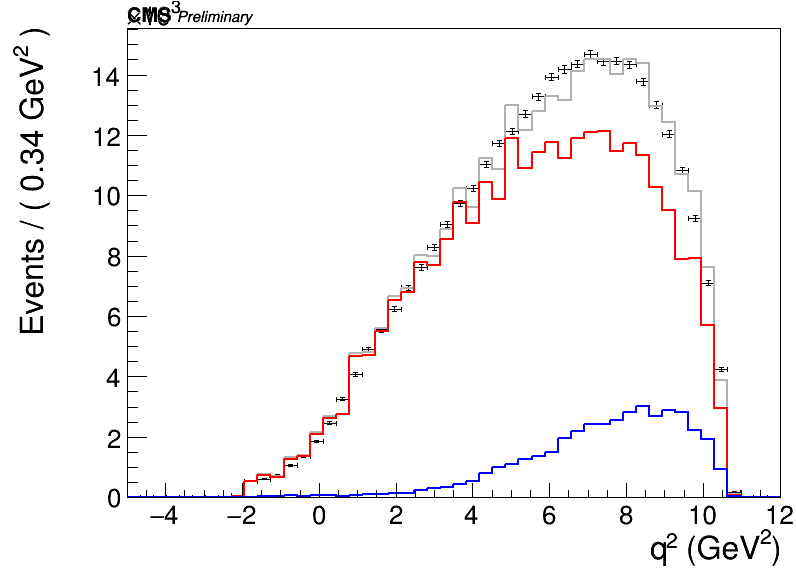

In [114]:
frame = q2.frame(rf.Title(""))
data.plotOn(frame, rf.MarkerStyle(1))

pdf_tot.plotOn(frame, rf.LineColor(16), rf.LineWidth(2), rf.Name('Sum'))
pdf_tot.plotOn(frame, rf.Components('pdf_mu'), rf.LineColor(2), rf.LineWidth(2), rf.Name('Mu'))
pdf_tot.plotOn(frame, rf.Components('pdf_tau'), rf.LineColor(4), rf.LineWidth(2), rf.Name('Tau'))
        
# i_pad = i_q2*N_cols + i_v + 1
# pad = canvas.cd(i_pad)
# pad.SetTopMargin(0.05)
# pad.SetBottomMargin(0.13)
# pad.SetRightMargin(0.03)
# pad.SetLeftMargin(0.22)
    
CMS_lumi.extraText = "     Preliminary"
c = drawOnCMSCanvas(CMS_lumi, frame)
# c.SetLogy()

print 'N data: {:.0f}'.format(h_q2['data'].Integral())
print 'N mu: {:.0f} +/- {:.0f}'.format(n_mu.getVal(), n_mu.getError())
print 'N tau: {:.0f} +/- {:.0f}'.format(n_tau.getVal(), n_tau.getError())
r = n_tau.getVal()/n_mu.getVal()
dr = r*np.hypot(n_mu.getError()/n_mu.getVal(), n_tau.getError()/n_tau.getVal())
print 'Raw yeld: {:.1f} +/- {:.1f} %'.format(100*r, 100*dr)

# Create RooFit workspace

In [115]:
q2 = rt.RooRealVar('q2', 'q^{2}', binning['q2'][1], binning['q2'][2], 'GeV^{2}')
M2_miss = rt.RooRealVar('M2_miss', 'M^{2}_{miss}', binning['M2_miss'][1], binning['M2_miss'][2], 'GeV^{2}')
Est_mu = rt.RooRealVar('Est_mu', 'E_{#mu}*', binning['Est_mu'][1], binning['Est_mu'][2], 'GeV')

In [116]:
data = rt.RooDataHist('data', 'Data', rt.RooArgList(q2, M2_miss, Est_mu), histo['data'])

In [117]:
dh_mu = rt.RooDataHist('dh_mu', 'mu', rt.RooArgList(q2, M2_miss, Est_mu), histo['mu'])
pdf_mu = rt.RooHistPdf('pdf_mu', 'pdf_mu', rt.RooArgSet(q2, M2_miss, Est_mu), dh_mu)
n_mu = rt.RooRealVar('n_mu', 'N_{#mu}', n_mu.getVal(), 0, 1.1*histo['data'].Integral())

dh_tau = rt.RooDataHist('dh_tau', 'tau', rt.RooArgList(q2, M2_miss, Est_mu), histo['tau'])
pdf_tau = rt.RooHistPdf('pdf_tau', 'pdf_tau', rt.RooArgSet(q2, M2_miss, Est_mu), dh_tau)
n_tau = rt.RooRealVar('n_tau', 'N_{#tau}', n_tau.getVal(), 0, 1.1*histo['data'].Integral())

In [118]:
pdf_tot = rt.RooAddPdf('pdftot', 'pdftot', rt.RooArgList(pdf_mu, pdf_tau), rt.RooArgList(n_mu, n_tau))
# pdf_tot.fitTo(data)

In [119]:
print 'N data =', histo['data'].GetEntries()
print 'N mu = {:.0f} +/- {:.0f}'.format(n_mu.getVal(), n_mu.getError())
print 'N tau = {:.0f} +/- {:.0f}'.format(n_tau.getVal(), n_tau.getError())
r = n_tau.getVal()/n_mu.getVal()
dr = r*np.hypot(n_mu.getError()/n_mu.getVal(), n_tau.getError()/n_tau.getVal())
print 'Raw yeld: {:.1f} +/- {:.1f} %'.format(100*r, 100*dr)

N data = 316427.0
N mu = 275771 +/- 0
N tau = 40656 +/- 0
Raw yeld: 14.7 +/- 0.0 %


# Plot the results by hand

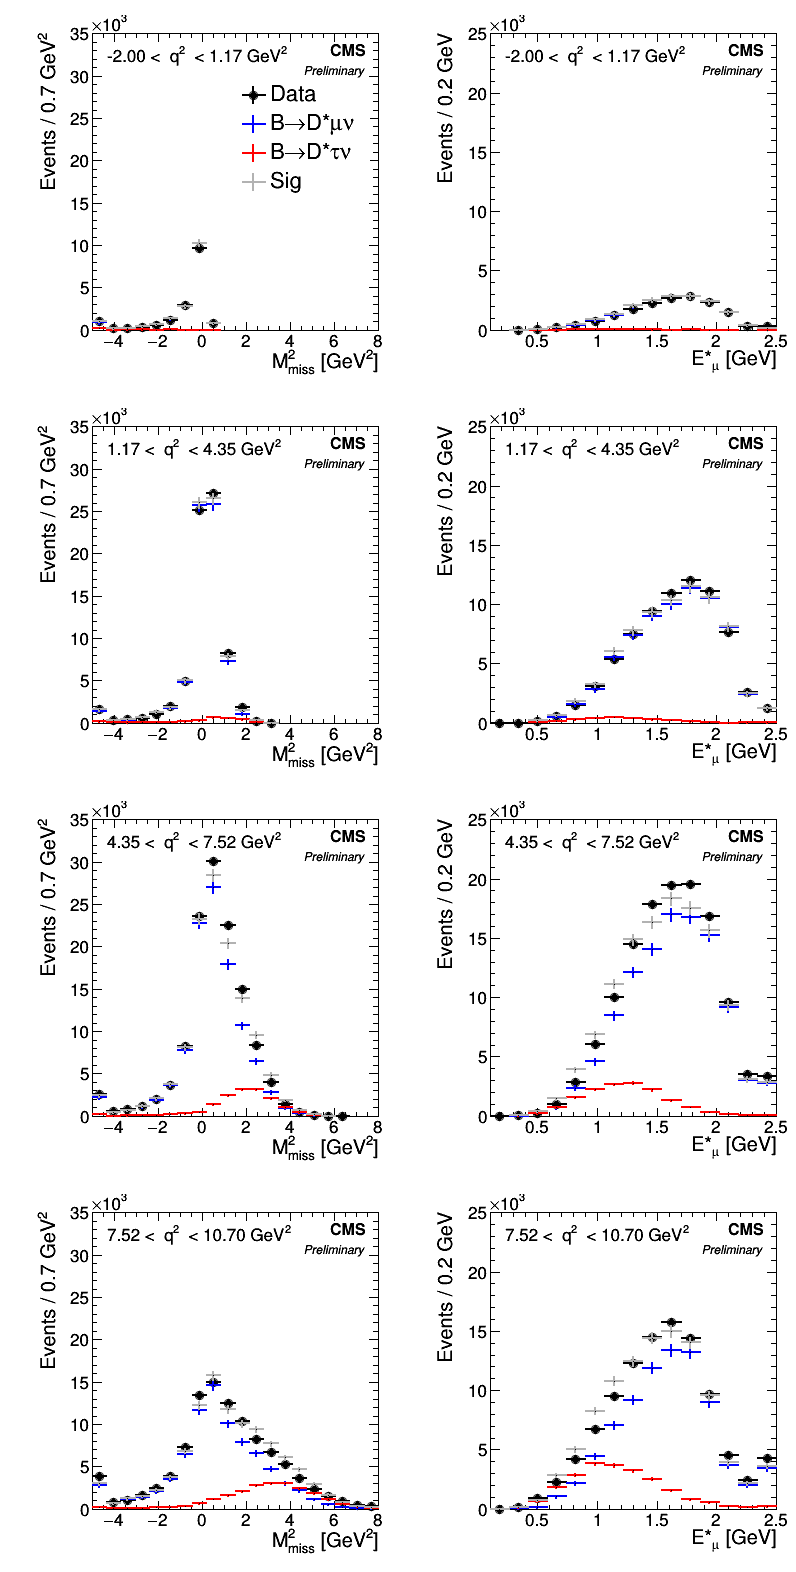

In [128]:
N_cols = len(binning.keys())-1
N_rows = binning['q2'][0]
canvas = rt.TCanvas('c_out', 'c_out', 50, 50, N_cols*400, 400*N_rows)
canvas.SetTickx(0)
canvas.SetTicky(0)
canvas.Divide(N_cols, N_rows)
canvas.dnd = []

CMS_lumi.extraText = "        Preliminary"
rt.TGaxis.SetMaxDigits(4)

q2_edges = np.linspace(binning['q2'][1], binning['q2'][2], 1+binning['q2'][0], True)
for i_q2 in range(binning['q2'][0]):
    q2_l = q2_edges[i_q2]
    q2_h = q2_edges[i_q2+1]

    q2_txt = '{:.2f} <  q^{{2}}  < {:.2f} GeV^{{2}}'.format(q2_l, q2_h)
    q2_cut = 'q2 > {:.2f} &&  q2 < {:.2f}'.format(q2_l, q2_h)

    for i_v, var in enumerate(['M2_miss', 'Est_mu']):        
        i_pad = i_q2*N_cols + i_v + 1
        pad = canvas.cd(i_pad)
        pad.SetTopMargin(0.05)
        pad.SetBottomMargin(0.13)
        pad.SetRightMargin(0.03)
        pad.SetLeftMargin(0.22)
        
        if var == 'M2_miss':
            axis_title = ['M^{2}_{miss} [GeV^{2}]', 'Events / {:.1f} GeV^{{2}}'.format(float(binning[var][2]-binning[var][1])/binning[var][0])]
        elif var == 'Est_mu':
            axis_title = ['E*_{#mu} [GeV]', 'Events / {:.1f} GeV'.format(float(binning[var][2]-binning[var][1])/binning[var][0])]
        
        
        sel = createSel(dSet['data'], analysis_selection)
        q2_sel = np.logical_and(dSet['data']['q2'] < q2_h, dSet['data']['q2'] > q2_l)
        sel = np.logical_and(sel, q2_sel)
        h_data = create_TH1D(dSet['data'][var][sel], name='hd'+str(i_q2)+var, title='',
                             axis_title = axis_title,
                             binning=binning[var], opt='overflow+underflow',
                            )
        h_data.Sumw2()
        if var == 'M2_miss':
            h_data.GetYaxis().SetRangeUser(0,35000)
        elif var == 'Est_mu':
            h_data.GetYaxis().SetRangeUser(0,25000)
        h_data.SetMarkerStyle(8)
        h_data.Draw()
        
        sel = createSel(dSet['mu'], analysis_selection)
        q2_sel = np.logical_and(dSet['mu']['q2'] < q2_h, dSet['mu']['q2'] > q2_l)
        sel = np.logical_and(sel, q2_sel)
        h_mu = create_TH1D(dSet['mu'][var][sel], name='h_mu_'+str(i_q2)+var, title='',
                             binning=binning[var], opt='overflow+underflow',
                            )
        h_mu.SetLineColor(4)
        h_mu.Sumw2()
        h_mu.Scale(n_mu.getVal()/histo['mu'].Integral())
        h_mu.Draw('SAME')
        
        sel = createSel(dSet['tau'], analysis_selection)
        q2_sel = np.logical_and(dSet['tau']['q2'] < q2_h, dSet['tau']['q2'] > q2_l)
        sel = np.logical_and(sel, q2_sel)
        h_tau = create_TH1D(dSet['tau'][var][sel], name='h_tau_'+str(i_q2)+var, title='',
                             binning=binning[var], opt='overflow+underflow',
                            )
        h_tau.SetLineColor(2)
        h_tau.Sumw2()
        h_tau.Scale(n_tau.getVal()/histo['tau'].Integral())
        h_tau.Draw('SAME')
        
        h_sum = h_tau.Clone('h_sum_'+str(i_q2)+var)
        h_sum.Add(h_mu)
        h_sum.SetLineColor(16)
        h_sum.Draw("SAME")
        
        CMS_lumi.CMS_lumi(pad, -1, 33, 0.75*1.3, 0.6*1.3)
        
        frame.SetMaximum(1.2*frame.GetMaximum())
        frame.GetYaxis().SetTitleOffset(1.7)
        
        l = rt.TLatex()
        l.SetTextAlign(11)
        l.SetTextSize(0.05)
        l.SetTextFont(42)
        l.DrawLatexNDC(0.26, 0.87, q2_txt)

        if i_pad == 1:
            leg = rt.TLegend(0.6, 0.5, 0.95, 0.82)
            leg.SetTextFont(42)
            leg.SetTextAlign(12)
            leg.SetLineWidth(1)
            leg.SetBorderSize(0)
            leg.AddEntry(h_data, 'Data', 'lep')
            leg.AddEntry(h_mu, 'B#rightarrowD*#mu#nu', 'le')
            leg.AddEntry(h_tau, 'B#rightarrowD*#tau#nu', 'le')
            leg.AddEntry(h_sum, 'Sig', 'le')
            leg.Draw()
            
        canvas.dnd.append([h_data, h_mu, h_tau, h_sum])

canvas.Draw()
canvas.SaveAs('/Users/olmo/Desktop/DataFitwSig.png')

# Plot the results w/ RooFit

In [24]:
N_cols = len(binning.keys())-1
N_rows = binning['q2'][0]
canvas = rt.TCanvas('c_out', 'c_out', 50, 50, N_cols*400, 400*N_rows)
canvas.SetTickx(0)
canvas.SetTicky(0)
canvas.Divide(N_cols, N_rows)

CMS_lumi.extraText = "        Preliminary"

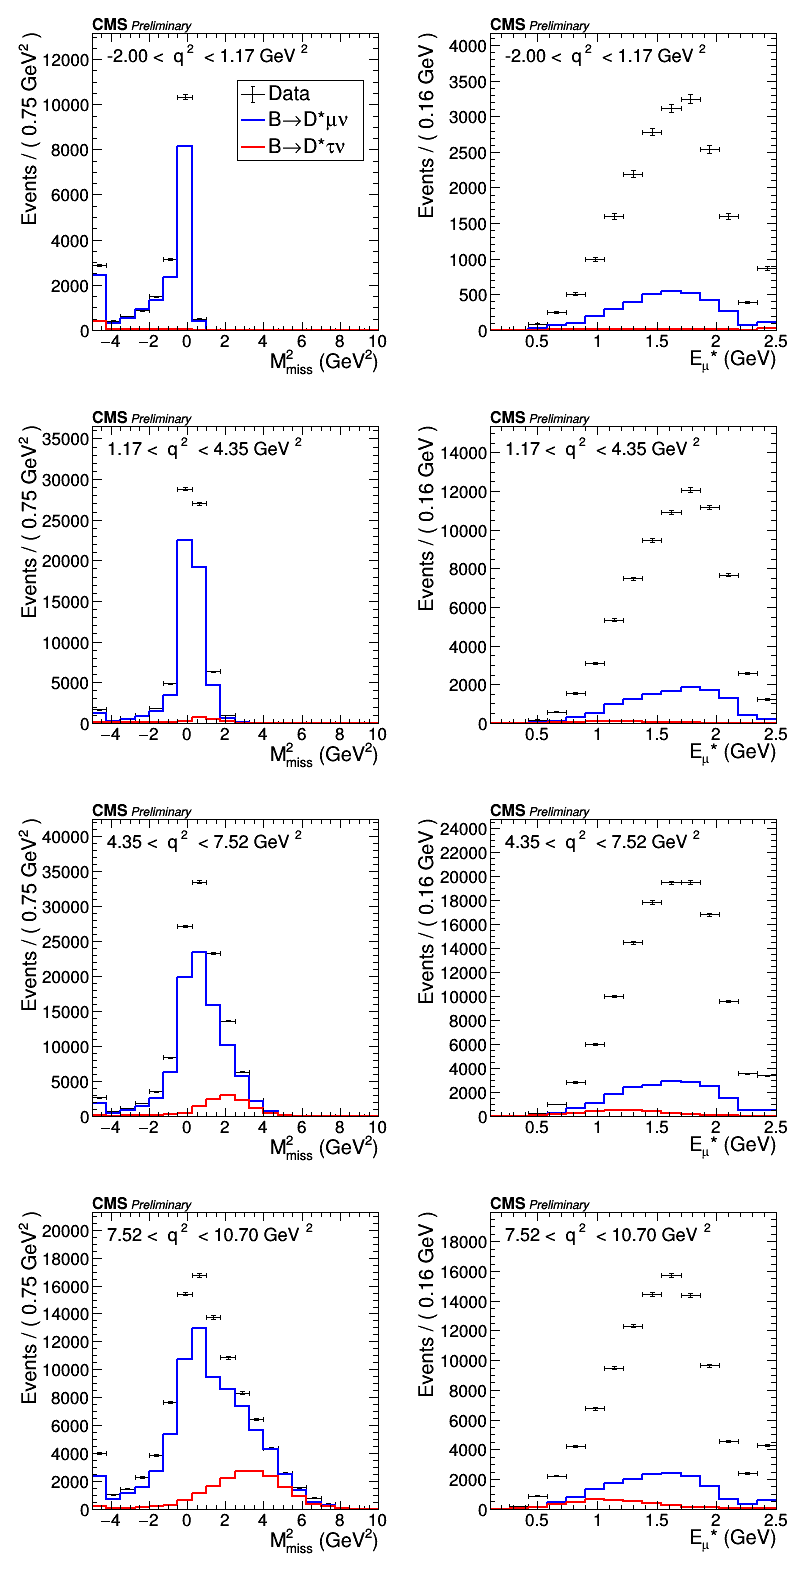

In [27]:
q2_edges = np.linspace(binning['q2'][1], binning['q2'][2], 1+binning['q2'][0], True)

for i_q2 in range(binning['q2'][0]):
    q2_l = q2_edges[i_q2]
    q2_h = q2_edges[i_q2+1]
    q2.setRange('q2_bin'+str(i_q2),q2_l,q2_h)
    M2_miss.setRange('q2_bin'+str(i_q2), binning['M2_miss'][1], binning['M2_miss'][2])
    Est_mu.setRange('q2_bin'+str(i_q2), binning['Est_mu'][1], binning['Est_mu'][2])

    q2_txt = '{:.2f} <  q^{{2}}  < {:.2f} GeV^{{2}}'.format(q2_l, q2_h)
    q2_cut = 'q2 > {:.2f} &&  q2 < {:.2f}'.format(q2_l, q2_h)

    for i_v, var in enumerate([M2_miss, Est_mu]):
        frame = var.frame(rf.Title(""))
        
        data.plotOn(frame, rf.CutRange('q2_bin'+str(i_q2)), rf.MarkerStyle(1), rf.Name('Data'))
        pdf_tot.plotOn(frame, rf.ProjectionRange('q2_bin'+str(i_q2)), rf.LineColor(4), rf.LineWidth(2), rf.Name('Mu'))
        pdf_tot.plotOn(frame, rf.Components('pdf_tau'), rf.ProjectionRange('q2_bin'+str(i_q2)), rf.LineColor(2), rf.LineWidth(2), rf.Name('Tau'))
        
        i_pad = i_q2*N_cols + i_v + 1
        pad = canvas.cd(i_pad)
        pad.SetTopMargin(0.05)
        pad.SetBottomMargin(0.13)
        pad.SetRightMargin(0.03)
        pad.SetLeftMargin(0.22)
        
        frame.Draw()
        CMS_lumi.CMS_lumi(pad, -1, 0, 0.75*1.3, 0.6*1.3)
        
        frame.SetMaximum(1.2*frame.GetMaximum())
        frame.GetYaxis().SetTitleOffset(1.7)
        
        l = rt.TLatex()
        l.SetTextAlign(11)
        l.SetTextSize(0.055)
        l.SetTextFont(42)
        l.DrawLatexNDC(0.26, 0.87, q2_txt)

        if i_pad == 1:
            leg = rt.TLegend(0.6, 0.6, 0.93, 0.82)
            leg.SetTextFont(42)
            leg.SetTextAlign(12)
            leg.SetLineWidth(1)
            leg.SetBorderSize(1)
            leg.AddEntry('Data', 'Data', 'lep')
            leg.AddEntry('Mu', 'B#rightarrowD*#mu#nu', 'l')
            leg.AddEntry('Tau', 'B#rightarrowD*#tau#nu', 'l')
            leg.Draw()

canvas.Draw()

In [26]:
# canvas.SaveAs('/Users/olmo/Desktop/RDst_fit.png')